<h2> Trabalho prático III: Detecção de fraude em cartões de crédito utilizando modelos de classificação.<h2>

<h3> 1. Introdução</h3>

<p> O conjunto de dados selecionado é referente ao histórico de fraudes em cartões de crédito de uma determinada empresa. O objetivo é determinar se alguma atividade do cartão é referente a alguma fraude ou não a partir de modelos de classificação, em seguida, avaliar os resultados.</p>

In [33]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [34]:
df = pd.read_csv("card_transdata.csv", sep = ',')
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


<h3> 2. Limpeza de dados e analise exploratória:</h3>

<h4> 2.2 Checando a existencia de valores nulos</h4>

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


<ul><li>Nâo há valores nulos no dataset</li></ul>

<h4> 2.3 Parametros que só podem ser verdadeiros ou falsos:</h4>

In [36]:
for feature in ['repeat_retailer','used_chip','used_pin_number','online_order','fraud']:
    print(feature,df[feature].unique(),sep=' : ')

repeat_retailer : [1. 0.]
used_chip : [1. 0.]
used_pin_number : [0. 1.]
online_order : [0. 1.]
fraud : [0. 1.]


<h4> 2.3 Verificando outliers</h4>

In [37]:
# Separando features do tipo numerico dos de tipo categóricos
numerical_features = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']
categorical_features =  ['repeat_retailer','used_chip','used_pin_number','online_order','fraud']

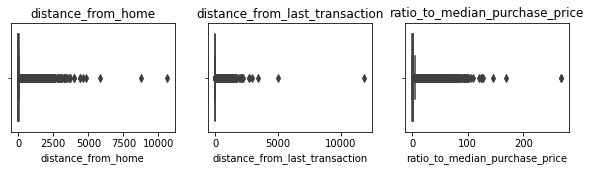

In [38]:
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(10,2))
position_matrix = [0,1,2]

count_var = 0

for feature in numerical_features:
    sns.boxplot(ax=axes[count_var],data=df, x=feature,hue='fraud')
    axes[position_matrix[count_var]].set_title(feature)
    count_var += 1

<ul><li>Por enquanto vamos assumir que os outlier se tratam de fraudes, pois são valores muito altos utilizados a uma distancia muito grande da casa do dono do cartão, portanto não serão removidos</li></ul>

<h4> 2.4 Descrevendo as features do dataset </h4>

<table style = 'float: center'>
<tr>
    <td style = 'text-align:left'>Coluna</td>
    <td style = 'text-align:left'>Descrição</td>
</tr>

<tr>
    <td style = 'text-align:left'> distance_from_home</td>
    <td style = 'text-align:left'> A distancia entre onde foi feita a transação e a casa do dono do cartão (em km)</td>
</tr>
    
<tr>
    <td style = 'text-align:left'> distance_from_last_transaction</td>
    <td style = 'text-align:left'> A distancia entre onde foram feitas a ultima e a atual transação (em Km)</td>
</tr>

<tr>
    <td style = 'text-align:left'> ratio_to_median_purchase_price</td>
    <td style = 'text-align:left'> A razão entre a transação mediana e a transação atual. Exemplo: mediana = 50, atual = 60 então "ratio_to_median_purchase_price = 50/60 </td>
</tr>

<tr>
    <td style = 'text-align:left'> repeat_retailer</td>
    <td style = 'text-align:left'> Define se a transação está sendo feita em um lugar onde o cartão é frequentemente utilizado </td>
</tr>

<tr>
    <td style = 'text-align:left'> used_chip</td>
    <td style = 'text-align:left'> Define se a transação foi realizada utilizando um chip RFID</td>
</tr>

<tr>
    <td style = 'text-align:left'> used_pin_number</td>
    <td style = 'text-align:left'> Define se foi utilizado o numero pin na transação</td>
</tr>

<tr>
    <td style = 'text-align:left'> online_order</td>
    <td style = 'text-align:left'> Define se a transação se trata de um pagamento online</td>
</tr>
</table>

<h4> 2.5 Verificando as combinações </h4>

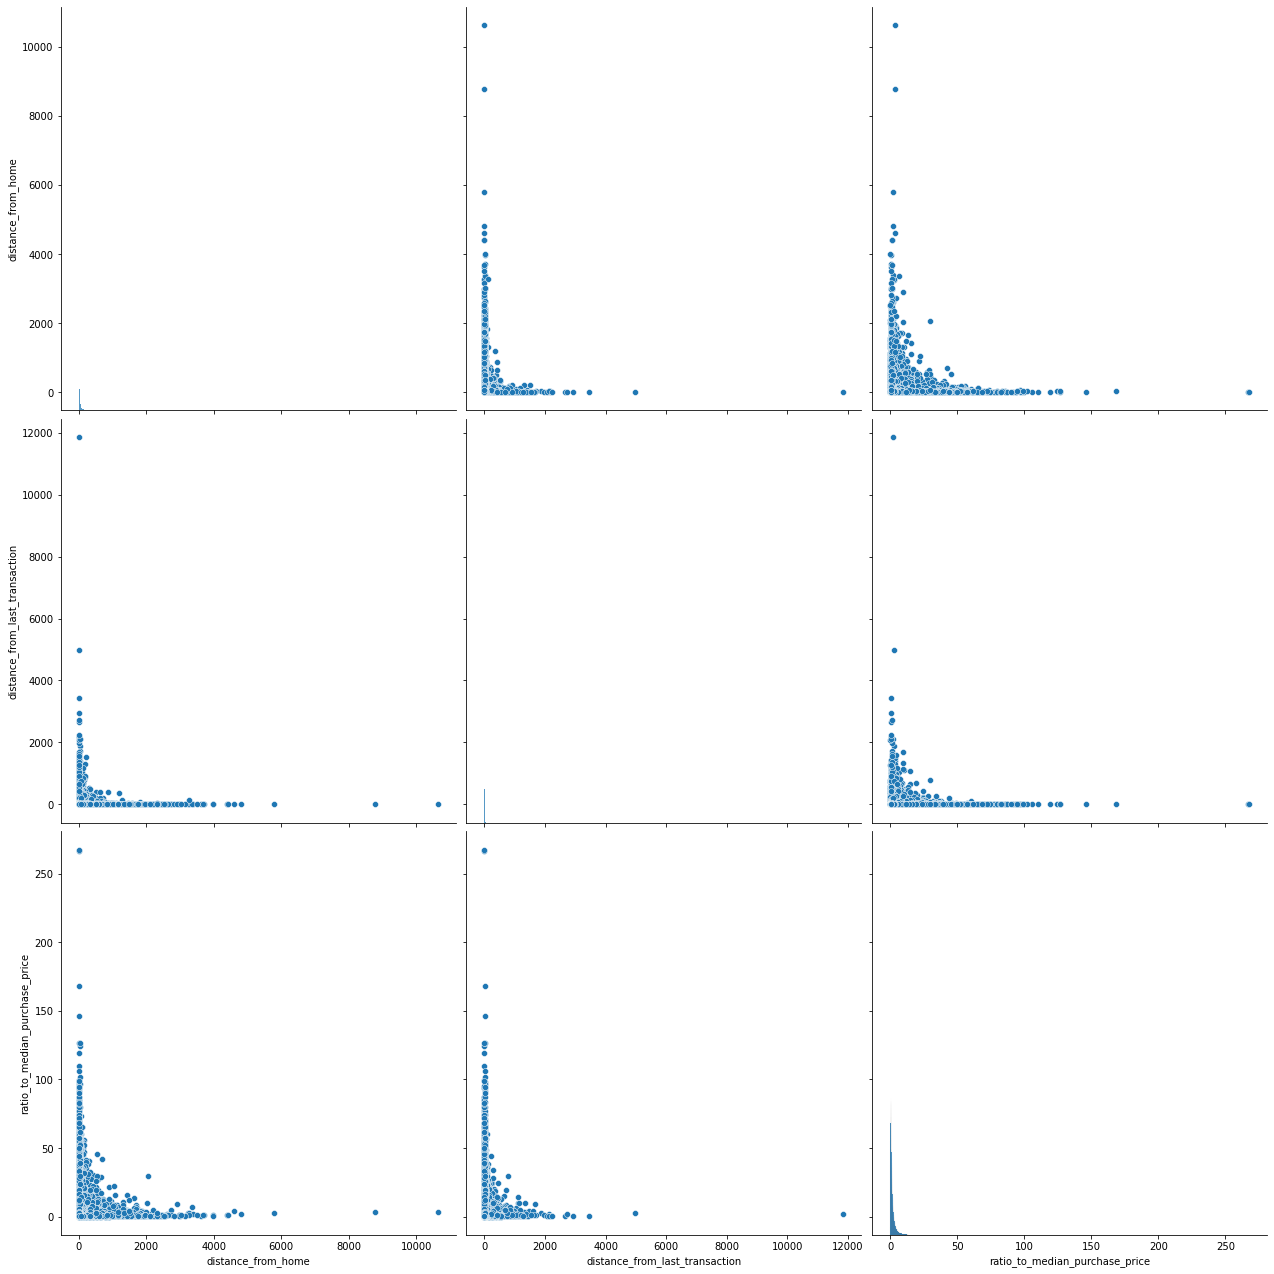

In [39]:
sns.pairplot(data=df[numerical_features], height=6, aspect=1)

<AxesSubplot:xlabel='online_order', ylabel='count'>

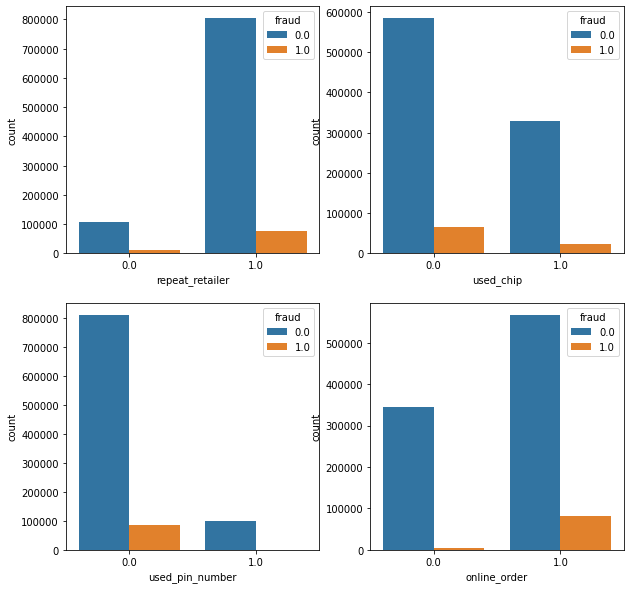

In [40]:
fig, axes = plt.subplots(2, 2, sharex=False, figsize =(10,10))
sns.countplot(ax=axes[0,0],x="repeat_retailer", data=df, hue='fraud')
sns.countplot(ax=axes[0,1],x="used_chip", data=df, hue='fraud')
sns.countplot(ax=axes[1,0],x="used_pin_number", data=df, hue='fraud')
sns.countplot(ax=axes[1,1],x="online_order", data=df, hue='fraud')

<h4> 2.6 Divisão de treino e teste </h4>

In [70]:
X = df.drop('fraud', axis='columns')
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Há', y_train.shape[0], 'dados de treino e', y_test.shape[0], 'dados de teste do total de',y.shape[0],'dados.')

Há 750000 dados de treino e 250000 dados de teste do total de 1000000 dados.


<h3>3. Modelagem</h3>

<h4>3.1 K-Nearest Neighbor</h4>

- Modelo para casos de classificação, como no nosso caso de classificação binária (dois tipos específicos, mutuamente exclusivos), mas também pode ser usado em casos de regressão.
- Baseado na distância euclidiana, a qual é um caso particular da distância de Minkowski.
- Baseado nas k observações do conjunto de treinamento que são mais idênticas ou próximas da nova observação.
- Modelo não paramétrico baseado em instância, por ter que calcular a diferença entre a observação teste com cada observação de treino.
- A previsão é determinada pela classe de maior reincidência entre os k vizinhos mais próximos.


<span>Analisando a proporção entre as classes.</span>

In [71]:
print('Dados:\n', y.value_counts(normalize = True).round(2),'\n')
print('Dados de treino:\n', y_train.value_counts(normalize = True).round(2),'\n')
print('Dados de teste:\n', y_test.value_counts(normalize = True).round(2))

Dados:
 0.0    0.91
1.0    0.09
Name: fraud, dtype: float64 

Dados de treino:
 0.0    0.91
1.0    0.09
Name: fraud, dtype: float64 

Dados de teste:
 0.0    0.91
1.0    0.09
Name: fraud, dtype: float64


<span>Evitar distorção por diferença de escala.</span>

In [72]:
scaler = StandardScaler()
X_train_default = scaler.fit_transform(X_train)
X_test_default= scaler.transform(X_test) 

In [73]:
print('Medias treino:', np.mean(X_train_default, axis = 0).round(2))
print('Desvio treino:', np.std(X_train_default, axis = 0).round(2))

print('Medias teste:', np.mean(X_test_default, axis = 0).round(2))
print('Desvio teste:', np.std(X_test_default, axis = 0).round(2))

Medias treino: [-0.  0. -0.  0. -0.  0. -0.]
Desvio treino: [1. 1. 1. 1. 1. 1. 1.]
Medias teste: [ 0.  0. -0.  0.  0. -0. -0.]
Desvio teste: [1.01 0.89 1.01 1.   1.   1.   1.  ]


<h5>3.1.1 Valor padrão</h5>

<span>Modelo com sua configuração padrão(k=5)</span>

In [74]:
def knn_default(X_train, y_train, X_test):
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred

In [75]:
y_train_default_pred = knn_default(X_train_default, y_train, X_train_default)
y_test_default_pred = knn_default(X_train_default, y_train, X_test_default)
acc_train_model= accuracy_score(y_train, y_train_default_pred).round(5)
acc_test_model= accuracy_score(y_test, y_test_default_pred).round(5)
print("No modelo de K=5 obtivemos a precisão",acc_train_model,"nos dados de treinamento e",acc_test_model,"nos dados de teste.")

No modelo de K=5 obtivemos a precisão 0.99938 nos dados de treinamento e 0.99875 nos dados de teste.


<h5>3.1.2 Valor ideal</h5>

<span>Analizando o melhor valor para o hiperparâmetro.</span>

In [58]:
#validação cruzada
kf = KFold(n_splits = 5, 
           shuffle = True, 
           random_state = 12
          )

In [60]:
def knn_score(X_train,y_train):
    scores_para_df_standard = []

    for i in range(1, 21):
        model = KNeighborsClassifier(n_neighbors = i)

        cv_scores = cross_val_score(model, 
                                    X_train, 
                                    y_train, 
                                    cv = kf
                                )
        
        dict_row_score = {'score_medio':np.mean(cv_scores),
                        'score_std':np.std(cv_scores), 'n_neighbors' : i
                        }
        
        scores_para_df_standard.append(dict_row_score)
        
    return scores_para_df_standard

In [61]:
scores_para_df = []
scores_para_df = knn_score(X_train_default,y_train)
df_scores = pd.DataFrame(scores_para_df)
df_scores.head()

,score_medio,score_std,n_neighbors
0,0.998736,0.000077,1
1,0.998436,0.000119,2
2,0.998763,0.000065,3
3,0.998507,0.000092,4
4,0.998728,0.000078,5


In [62]:
df_scores

,score_medio,score_std,n_neighbors
0,0.998736,0.000077,1
1,0.998436,0.000119,2
2,0.998763,0.000065,3
3,0.998507,0.000092,4
4,0.998728,0.000078,5
5,0.998535,0.000122,6
6,0.998707,0.000101,7
7,0.998475,0.000090,8
8,0.998617,0.000099,9
9,0.998491,0.000110,10


<span>Analisando graficamente.</span>

In [63]:
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
df_scores.head()

,score_medio,score_std,n_neighbors,limite_inferior,limite_superior
0,0.998736,0.000077,1,0.998659,0.998813
1,0.998436,0.000119,2,0.998317,0.998555
2,0.998763,0.000065,3,0.998697,0.998828
3,0.998507,0.000092,4,0.998415,0.998598
4,0.998728,0.000078,5,0.998650,0.998806


In [64]:
df_scores

,score_medio,score_std,n_neighbors,limite_inferior,limite_superior
0,0.998736,0.000077,1,0.998659,0.998813
1,0.998436,0.000119,2,0.998317,0.998555
2,0.998763,0.000065,3,0.998697,0.998828
3,0.998507,0.000092,4,0.998415,0.998598
4,0.998728,0.000078,5,0.998650,0.998806
5,0.998535,0.000122,6,0.998412,0.998657
6,0.998707,0.000101,7,0.998606,0.998808
7,0.998475,0.000090,8,0.998385,0.998565
8,0.998617,0.000099,9,0.998518,0.998716
9,0.998491,0.000110,10,0.998380,0.998601


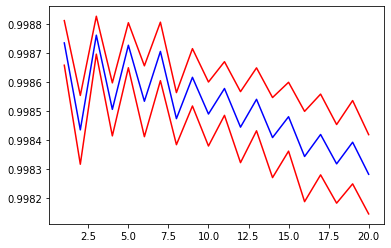

In [65]:
plt.plot(df_scores['n_neighbors'], df_scores['limite_inferior'], 
         color = 'r'
        )

plt.plot(df_scores['n_neighbors'], df_scores['score_medio'], 
         color = 'b'
        )

plt.plot(df_scores['n_neighbors'], df_scores['limite_superior'], 
         color = 'r'
        )

<span>Gerando o modelo com o melhor hiperparâmetro.</span>

In [66]:
best_k = df_scores.loc[df_scores.score_medio == df_scores.score_medio.max(), 
                                'n_neighbors'].values[0]
best_k

3

In [67]:
def knn_best(X_train, y_train,X_test):
    knn = KNeighborsClassifier(n_neighbors = best_k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred


In [76]:
y_train_best_pred = knn_best(X_train_default, y_train, X_train_default)
y_test_best_pred = knn_best(X_train_default, y_train, X_test_default)

acc_train_model= accuracy_score(y_train, y_train_best_pred).round(5)
acc_test_model= accuracy_score(y_test, y_test_best_pred).round(5)

print("No modelo de  K=",best_k,"obtivemos a precisão",acc_train_model,"nos dados de treinamento e",acc_test_model,"nos dados de teste.")

No modelo de  K= 3 obtivemos a precisão 0.99956 nos dados de treinamento e 0.99879 nos dados de teste.


<h5>3.1.3 Matriz de confusão</h5>

<span>Analisando os acertos e erros do modelo usando a matriz de confusão.</span>

In [77]:
cm_knn = confusion_matrix(y_test, y_test_best_pred)
cm_knn

array([[228137,    121],
       [   182,  21560]], dtype=int64)

<AxesSubplot:>

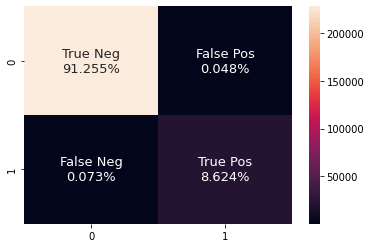

In [81]:
groups = ['True Neg','False Pos','False Neg','True Pos']
percentage_values = ['{0:.3%}'.format(value) for value in cm_knn.flatten() / np.sum(cm_knn)]

labels = [f"{a}\n{b}" for a, b in zip(groups, percentage_values)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm_knn, annot=labels, annot_kws={'fontsize':13}, fmt='')

In [83]:
print(classification_report(y_test, y_test_best_pred, target_names=['Não há fraude', 'Há fraude']))

               precision    recall  f1-score   support

Não há fraude       1.00      1.00      1.00    228258
    Há fraude       0.99      0.99      0.99     21742

     accuracy                           1.00    250000
    macro avg       1.00      1.00      1.00    250000
 weighted avg       1.00      1.00      1.00    250000



<h4>3.2 Decision Tree Classifier</h4>

- Algoritmos baseados em árvores de decisão geram modelos de alta precisão e são robustos em relação a outliers.

- Eles funcionam de forma semelhante a um fluxograma, estabelecendo nós que se relacionam entre si por uma hierarquia. 

- Os nós-folha são os resultados finais e o nó-raiz é um dos atributos do dataset. Os nós são ligados entre regras "se-então", na qual o algoritmo se pergunta acerca de uma regra, uma condição que ditará o caminho a ser seguido na árvore, até chegar a um resultado final. 

- O algoritmo realiza cálculos que definem a posição de cada variável na árvore com base no ganho de informação e a entropia.

In [84]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
predictions = decision_tree_model.predict(X_test)

In [85]:
accuracy_score(y_test, predictions)

0.999988

A acurácia do modelo já apresenta um valor alto, mas a fim de explorar com mais profundidade os resultados, iremos analisar a matriz de confusão e o classification report.

In [86]:
cm = confusion_matrix(y_test, predictions)
cm

array([[228257,      1],
       [     2,  21740]], dtype=int64)

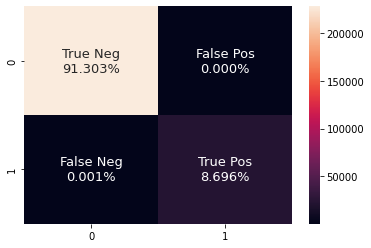

In [87]:
groups = ['True Neg','False Pos','False Neg','True Pos']
percentage_values = ['{0:.3%}'.format(value) for value in cm.flatten() / np.sum(cm)]

labels = [f"{a}\n{b}" for a, b in zip(groups, percentage_values)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, annot_kws={'fontsize':13}, fmt='');

In [88]:
print(classification_report(y_test, predictions, target_names=['Não há fraude', 'Há fraude']))

               precision    recall  f1-score   support

Não há fraude       1.00      1.00      1.00    228258
    Há fraude       1.00      1.00      1.00     21742

     accuracy                           1.00    250000
    macro avg       1.00      1.00      1.00    250000
 weighted avg       1.00      1.00      1.00    250000



In [89]:
def generate_feature_importance(model, X, y):
    return permutation_importance(model, X, y, n_repeats=10, random_state=0)

def info_feature_importance(model, X_test, y_test):
    feature_importance = generate_feature_importance(model, X_test, y_test)

    column_names = X_test.columns
    result = pd.Series(feature_importance.importances_mean, index=column_names)
    print(result.sort_values(ascending=False))

Analisando a importância de cada feature, podemos observar que nenhuma feature está impactando negativamente o modelo e que a variável "ratio_to_median_purchase_price", que determina a razão entre a transação mediana e a atual, é a que mais tem influência sob o modelo, seguida da informação de se a transação foi online e a distância da casa do dono do cartão.

A partir disso, podemos concluir que valores de compras muito diferentes do usual têm mais chances de indicar uma fraude, principalmente se essa compra for online ou de uma localização muito distante de onde o comprador mora.

In [90]:
info_feature_importance(decision_tree_model, X_test, y_test)

ratio_to_median_purchase_price    0.111727
online_order                      0.051678
distance_from_home                0.036174
used_pin_number                   0.017146
used_chip                         0.016556
distance_from_last_transaction    0.011571
repeat_retailer                   0.004222
dtype: float64


Por fim, analisaremos uma representação gráfica da árvore de decisão gerada com os dados do dataset, a fim de validar as conclusões obtidas.

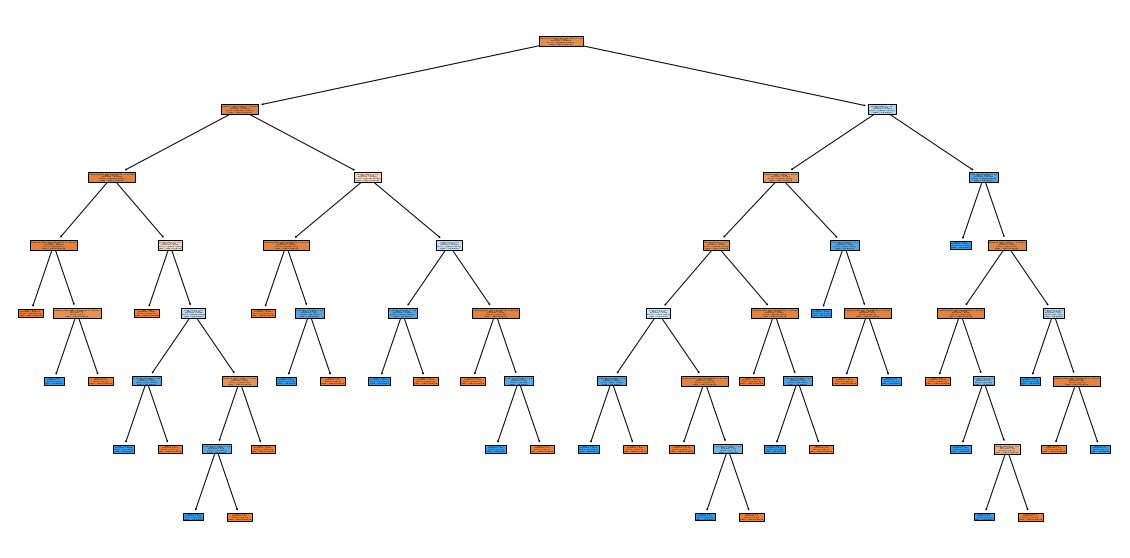

In [91]:
fig = plt.figure(figsize=(20, 10))

plot_tree(decision_tree_model, 
            filled=True,
            feature_names=X.columns,
            class_names=['Não há fraude', 'Há fraude'])
plt.show()

A raiz recebe o dataset completo e faz uma pergunta de verdadeiro ou falso. Essa pergunta divide o dataset pelos próximos dois nós. A parcela dos dados que responder a pergunta de forma negativa vai para o nó da direita e o restante (positivo) vai para o nó da esquerda. Esse processo se repete até o final da árvore.

A visualização da representação da árvore confirma as conclusões obtidas anteriormente.

Maiores variações nos valores de transação, compras online e maiores distâncias de casa são os fatores que mais indicam fraudes. 

<h4>3.3 Naive Bayes</h4>

- Naive Bayes é um algoritmo de classificação, baseado no "teorema de Bayes" que usa como conceito a probabilidade.

- Leva como premissa a suposição de independência entre as variáveis, isso explica o motivo de receber Naive (ingênuo). Porém, é um algoritmo muito rápido e usado em diversas aplicações.

- Suas principais aplicações são para análise de crédito, detecção de SPAM, diagnósticos médicos ou busca por falhas em sistemas mecânicos.

In [92]:
df.fraud.value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

In [93]:
# Matriz de variáveis explicativas
X = df.drop(['fraud'], axis =1)
# Variável target
Y = df['fraud']

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1237)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(700000, 7)
(300000, 7)
(700000,)
(300000,)


In [95]:
gnb = GaussianNB()
multi = MultinomialNB()
bern = BernoulliNB()

gnb.fit(X_train, Y_train)
multi.fit(X_train, Y_train)
bern.fit(X_train, Y_train)

BernoulliNB()

- Gaussian Naive Bayes: é o método indicado para quando as variáveis independentes são contínuas e têm distribuição normal. Um exemplo seria tentar prever o risco de uma pessoa portar uma doença a partir de vários indicadores sanguíneos.

In [96]:
gnb.score(X_test, Y_test)

0.9508

- Multinominal Naive Bayes: as variáveis independentes também são discretas, mas agora são multinominais, o que significa que elas têm mais de um valor possível, como os possíveis resultados de uma jogada de dado. Pense em prever o grau de risco de crédito com base no estado civil das pessoas, que pode ter várias categorias: solteiro, casado, divorciado, viúvo.

In [97]:
multi.score(X_test, Y_test)

0.91941

- Bernoulli Naive Bayes: usado quando as variáveis independentes são discretas, mas apenas dois valores são possíveis, como os possíveis resultados de jogar uma moeda. Um exemplo seria tentar prever o grau com que uma pessoa vai gostar de um filme com base no seu sexo.

In [98]:
bern.score(X_test, Y_test)

0.9126766666666667

 - Testamos os três tipos de modelo do Naive Bayes e o que possui maior acurácia é o Gaussian, chegando em um percentual de 95%. 

In [99]:
conf_mat_df = pd.DataFrame(data = conf_mat, 
                           index = ['Actual Negative: 0', 'Actual Positive: 1'], 
                           columns = ['Predict Negative: 0', 'Predict Positive: 1']
                          )

sns.heatmap(conf_mat_df, 
            annot = True, 
            fmt = 'd', 
            cmap = 'YlGnBu'
           );

conf_mat = confusion_matrix(Y_test, Y_pred)

print('Confusion matrix\n\n', conf_mat)

print('\nTrue Positives(TP) = ', conf_mat[1,1])

print('\nTrue Negatives(TN) = ', conf_mat[0,0])

print('\nFalse Positives(FP) = ', conf_mat[0,1])

print('\nFalse Negatives(FN) = ', conf_mat[1,0])

NameError: name 'conf_mat' is not defined